In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Bio.PDB.Polypeptide as pp
%matplotlib inline

In [2]:
AA = list(pp.aa1)

In [3]:
path = "/Users/macbook/Documents/perturbation-networks/dms_data"
protein_path = "/Users/macbook/Documents/perturbation-networks/proteins"

In [4]:
def PlotHeatmap(dataframe, save_as=None, vmin=None, vmax=None):
    """Plot heatmap of dataframe values.
    
    Parameters:
        dataframe: data to plot
        save_as: name of file to save. If None, image is not saved
        vmin, vmax: min and max values for colorscale
    """
    # Set missing values gray 
    sns.set(rc={'axes.facecolor':'94A3A8'})
    # Set size to match dataframe dimensions
    w = len(dataframe.columns)
    h = len(dataframe.index)
    ratio = w//h
    plt.figure(figsize=(10*ratio,10))
    heatmap = sns.heatmap(dataframe, cmap='RdBu_r', center=0, cbar=True, square=True, vmin=vmin, vmax=vmax)
    if save_as:
        fig = heatmap.get_figure()
        fig.savefig(f'{save_as}.png')
    return

### 1be9

In [5]:
functional_1be9 = pd.read_csv(os.path.join(path, "1be9-functional.csv"), header=None)
functional_1be9.index = AA

In [6]:
# Secuencia? Si ponemos los aminoácidos en orden alfabético, la secuencia que da es distinta a la del artículo 

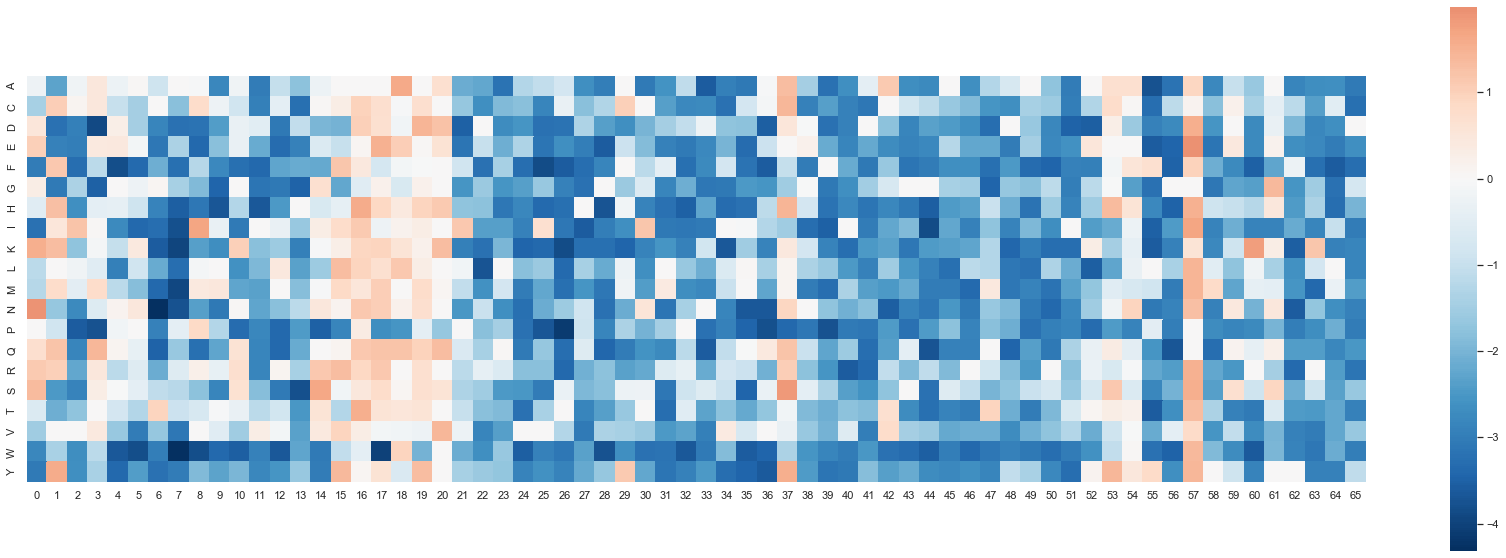

In [7]:
PlotHeatmap(functional_1be9)

In [34]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
def highlight(s):
    is_max = s == 0
    return ['background-color: yellow' if v else '' for v in is_max]
functional_1be9.style.apply(highlight)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
A,-0.222332,-2.305510,-0.182793,0.464723,-0.253838,0.037103,-0.875222,0.000000,-0.039856,-2.791440,-0.196022,-2.989930,-1.029330,-1.771140,-0.272271,0.000000,0.000000,0.000000,1.629390,0.000000,0.660960,-2.145770,-2.227470,-3.174750,-1.263050,-1.062520,-0.783787,-2.661760,-2.963370,0.000000,-3.056210,-2.570770,-1.101160,-3.596150,-2.946920,-3.070270,-0.077629,1.321530,-1.464880,-3.207880,-2.648030,-0.445864,1.111750,-2.670650,-2.726970,0.000000,-2.636880,-1.274790,-0.721120,0.000000,-1.729230,-3.028310,0.000000,0.670032,0.675185,-3.738530,-3.158830,0.927234,-2.778910,-1.011820,-1.622890,0.000000,-2.827960,-2.683680,-2.620470,-3.046280
C,-1.448470,1.051250,0.111444,0.500907,-0.991233,-1.459270,0.000000,-1.813510,0.783254,-0.216557,-0.850503,-2.958080,-0.436023,-3.232850,0.034374,0.306776,0.979843,0.723659,-0.051781,0.713550,0.000000,-1.661960,-2.615980,-1.881260,-1.818810,-2.845110,-0.318651,-1.790680,-1.306480,1.018590,0.000000,-2.393670,-2.779600,-2.722440,-3.227750,-0.771153,-0.087470,1.396070,-2.893900,-2.351780,-2.895390,-3.114510,0.000000,-0.820576,-1.136000,-1.615070,-1.901580,-2.560500,-2.618830,-1.415430,-1.580040,-2.965200,-1.291850,0.777265,0.043065,-3.268460,-1.135060,0.163895,-1.803720,0.203971,-1.448470,-0.420571,-1.164430,-2.353580,-0.484769,-3.245830
D,0.517976,-3.207420,-2.935330,-3.872170,0.264923,-1.478980,-2.830890,-3.195870,-3.163190,-2.407770,-0.347024,-0.492530,-3.064930,-1.081620,-1.965630,-2.046220,1.021540,0.669144,-0.170533,1.456420,1.267220,-3.514710,0.000000,-2.708160,-2.563830,-3.198780,-3.162010,-1.330170,-2.387470,-2.637950,-1.994480,-1.472070,-1.044700,-0.229131,-1.720830,-1.756390,-3.545210,0.523862,-0.018727,-3.212430,-2.906370,0.000000,-1.768180,-2.833760,-2.337170,-2.436700,-2.651510,-3.268520,0.000000,-1.647010,-2.788660,-3.496070,-3.527860,0.270891,-1.594190,-2.895680,-2.760390,1.556460,-2.555590,0.000000,-2.718420,-0.350573,-1.949880,-2.789360,-2.649820,0.000000
E,1.021480,-2.907970,-2.984080,0.421874,0.446675,-0.124015,-3.102180,-1.365560,-3.393910,-1.802390,-0.320126,-2.148160,-3.315700,-2.899270,-0.635288,-0.998627,0.083338,1.516320,1.068680,0.050885,0.614363,-3.144670,-0.987045,-2.101600,-1.318930,-3.137540,-2.630390,-2.968730,-3.597130,-0.924696,-1.869330,-2.903650,-3.054890,-2.767090,-2.009840,-3.309480,-0.927597,0.000000,0.230572,-2.184420,-2.845810,-2.200610,-2.703380,-2.865650,-2.777610,-1.234420,-2.224320,-2.226770,-2.985450,-1.473620,-2.766440,-2.612340,0.526570,0.000000,0.000000,-3.551320,-3.444310,1.985670,-3.151150,0.437476,-2.754060,0.182164,-2.663220,-2.777280,-3.000390,-2.646950
F,-2.984250,1.169390,-3.256920,-1.183390,-3.806630,-3.342430,-2.116900,-3.245370,-1.216540,-2.768500,-3.244580,-3.390100,-2.294400,-2.186380,-2.213130,1.178100,0.445606,-0.762471,-0.123931,-0.012455,0.000000,-0.851325,-3.228830,-1.431310,-3.297540,-3.847880,-3.554260,-3.255710,-2.847620,0.000000,-1.146320,-0.446318,-3.253150,-2.732220,-0.781212,-3.163610,-3.570980,-1.022880,-3.003890,0.000000,-2.182660,-3.063360,-1.637960,-3.152710,-3.000270,-2.617640,-2.651510,-3.247020,-2.461740,-3.309360,-3.429480,-2.895830,-2.944270,-0.115598,0.541135,0.669597,-3.464900,0.992516,-2.083870,-2.716440,-3.523260,-2.292010,-0.258761,-3.253950,-3.577280,-3.300570
G,0.302711,-3.037160,-1.376780,-3.514530,0.000000,-0.206815,0.066936,-1.438320,-1.901330,-3.433100,0.000000,-3.146990,-3.079080,-3.466450,0.666202,-2.221800,-0.528823,0.221760,-0.717750,0.232830,0.000000,-2.533240,-1.585890,-2.556860,-2.382620,-1.627940,-2.922180,-3.225780,0.000000,-1.593330,-0.609460,-2.833850,-2.080050,-3.107350,-3.081160,-2.481310,-2.517930,-1.556580,-0.016456,-3.081850,-2.644950,-1.493790,-0.741997,0.000000,0.000000,-1.416980,-1.490670,-3.449720,-1.658050,-1.807760,-1.121390,-2.981710,-1.139360,-0.017028,-2.368690,-3.220190,0.000000,0.000000,-3.101380

In [ ]:
# PLVTGPCAVLGI

### 3dqw

In [8]:
funct_3dqw = pd.read_csv(os.path.join(path, "3dqw-functional.csv"), index_col=0)
funct_3dqw = funct_3dqw[['Scores']]

In [9]:
# Functional scores are the negative of the scores in the file 
funct_3dqw['Scores'] = funct_3dqw['Scores'].apply(lambda x:-x)

In [10]:
# Use index to get position list 
positions = []
index_list = list(funct_3dqw.index)
for index in index_list:
    #index has format p.AAA#AAA
    original = pp.three_to_one(index[2:5].upper())
    position = original+index[5:-3]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
AAstop = AA + ['*']
functional_3dqw = pd.DataFrame(index=AAstop, columns=positions, dtype=np.float64)

In [11]:
for index, row in funct_3dqw.iterrows():
    #index has format p.AAA#AAA
    original = index[2:5].upper()
    mutation = index[-3:].upper()
    if pp.is_aa(mutation):
        original = pp.three_to_one(original)
        mutation = pp.three_to_one(mutation)
        position = original+index[5:-3]
        functional_3dqw.at[mutation, position] = row['Scores']
    else:
        original = pp.three_to_one(original)
        position = original+index[5:-3]
        functional_3dqw.at['*', position] = row['Scores']

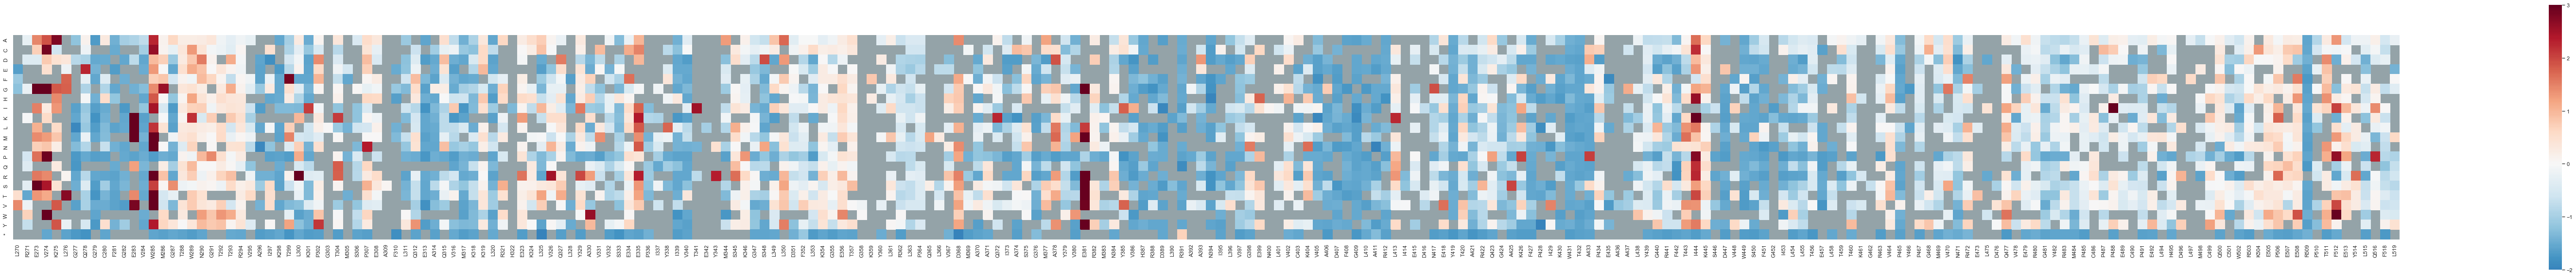

In [12]:
PlotHeatmap(functional_3dqw, vmin=-2, vmax=3)

### 1d5r

In [13]:
file = os.path.join(path, "1d5r_functional.csv")
funct_1d5r = pd.read_csv(file, header=0, index_col=0, usecols=[0, 6, 8, 10])

In [14]:
# Use index to get position list 
positions = []
index_list = list(funct_1d5r.index)
for index in index_list:
    #index has format A#A
    position = index[:-1]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons, '~' for deletions
AAstop = AA + ['*', '~']
functional_1d5r = pd.DataFrame(index=AAstop, columns=positions, dtype=np.float64)

In [15]:
# If high confidence, we keep the cum_score, else, we keep imputed_score
for index, row in funct_1d5r.iterrows():
    original = index[:-1]
    mutation = index[-1]
    if row[1] == 'VERDADERO':
        functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Cum_score']
    else:
        functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Imputed_Score']

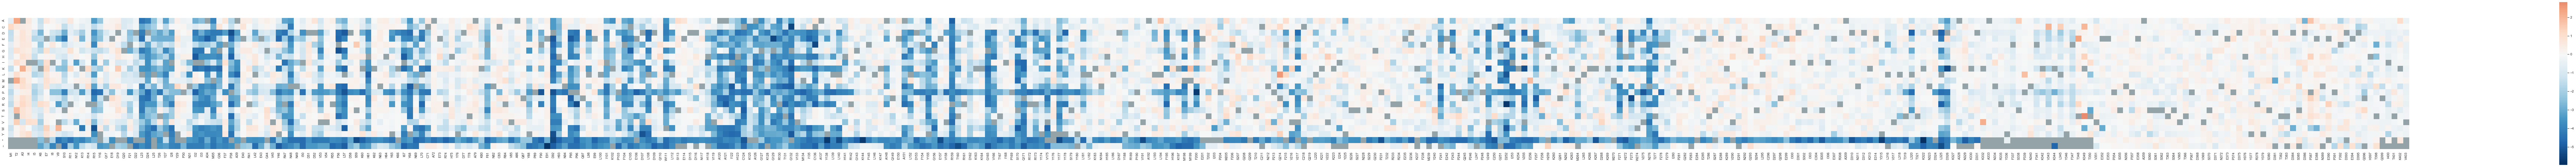

In [16]:
PlotHeatmap(functional_1d5r)

### 4bz3

In [17]:
file = os.path.join(path, "4bz3_functional.csv")
# We are keeping selection with 128ug/mL AMP at 37C
funct_4bz3 = pd.read_csv(file, header=0, usecols=[1,2,3,12]) 

In [18]:
# Use wt residue and position to get position list 
positions = set()
for index, row in funct_4bz3.iterrows():
    positions.add(row[0]+str(row[1]))
positions = list(positions)
# Sort according to position number
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
AAstop = AA + ['*']
functional_4bz3 = pd.DataFrame(index=AAstop, columns=positions, dtype=np.float64)

In [19]:
for index, row in funct_4bz3.iterrows():
    original = row['wt residue']+str(row['position'])
    mutation = row['variant residue']
    functional_4bz3.at[mutation, original] = funct_4bz3.at[index, '128ug/mL_AMP_37C']

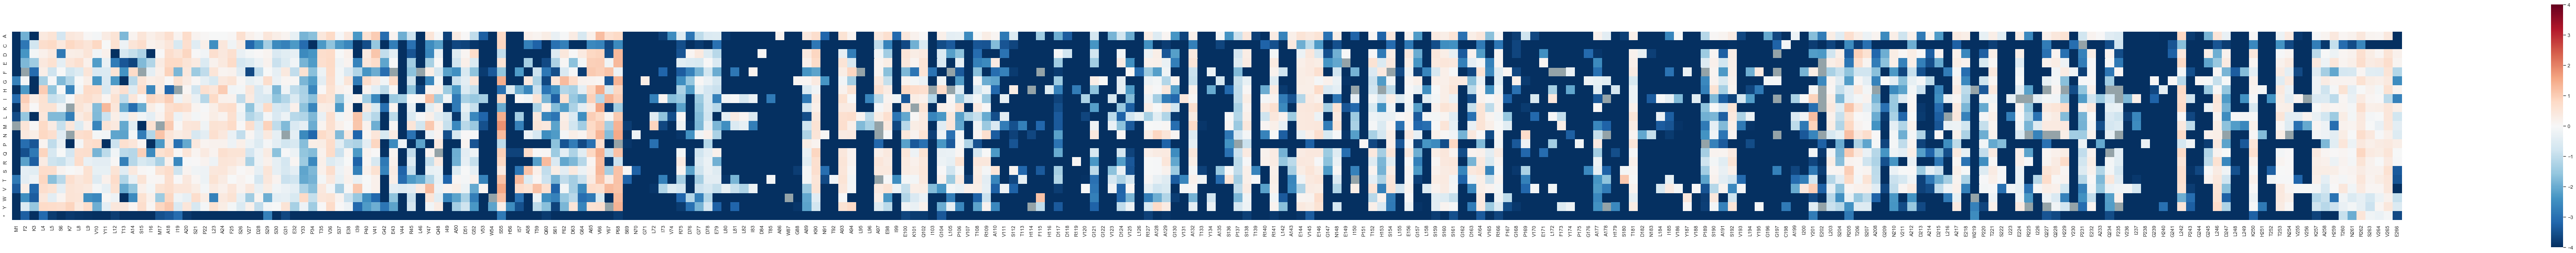

In [20]:
PlotHeatmap(functional_4bz3, vmin=-4, vmax=4)

### 1nd4

In [21]:
def GetDataFrame(file):
    """Get dataframe and fix format issues."""
    df = pd.read_csv(file, sep='\t', skiprows=(0), lineterminator='\n', header = [1,2], index_col = [0])
    df.columns = pd.MultiIndex.from_tuples([(int(ix[0]), ix[1].rstrip()) for ix in df.columns.tolist()])
    return df
# mi yo del pasado escribió eso, no recuerdo por qué necesitaba todo eso para que sirviera, pero es por el formato de 
# los txt

In [22]:
file = os.path.join(path, "1nd4-functional/KKA2_S1_Kan12_L1.aadiff.txt")
# We are keeping selection with 1:2 kanamycin
funct_1nd4 = GetDataFrame(file) 
funct_1nd4 = funct_1nd4.drop(funct_1nd4.index[range(20,40)])

In [23]:
funct_1nd4.at['Delta-G', (1, 'M')] = np.NaN # Vale 72202 y sospecho está mal

In [24]:
# Use header to get position list 
positions = [col[1]+str(col[0]) for col in funct_1nd4.columns]
# AA list as index
functional_1nd4 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [25]:
for index in funct_1nd4.index:
    for col in funct_1nd4.columns:
        position = col[1]+str(col[0])
        mutation = index[-1]
        value = funct_1nd4.at[index, col]
        functional_1nd4.at[mutation, position] = np.log10(value)

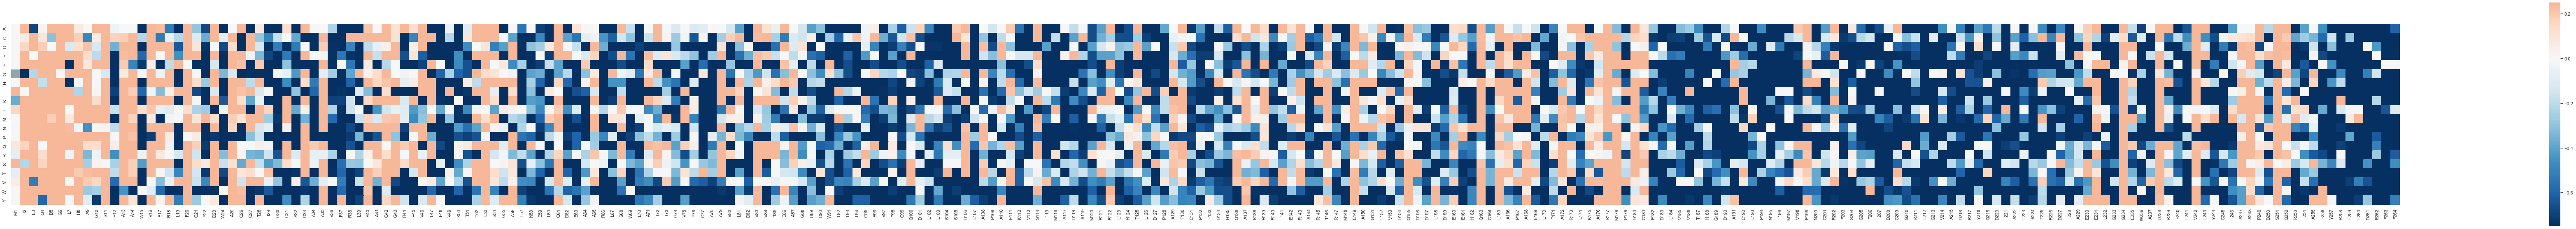

In [26]:
PlotHeatmap(functional_1nd4, vmax=0.25, vmin=-0.75)